In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from joblib import load

from sklearn.model_selection import train_test_split
from sksurv.util import Surv

# Plot style
sns.set(style="whitegrid")

# ------------------------------------------------------------
# 1. Paths and data loading
# ------------------------------------------------------------

BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"
RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

# Load processed dataset from Notebook 1
df = pd.read_parquet(DATA_DIR / "scania_processed.parquet")
print(df.shape)
df.head()


(23550, 79)


,171_0,666_0,837_0,167_0,167_1,167_2,167_3,167_4,167_6,167_7,...,Spec_7_Cat0,Spec_7_Cat1,Spec_7_Cat2,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,RUL,in_study_repair,vehicle_id
0,10189950.0,372685.0,41670.0,0.0,811605.0,1644061.0,560460.0,873435.0,0.0,0.0,...,True,False,False,False,False,False,False,2.6,0,0
1,5648790.0,289371.0,68717.0,10415.0,9137870.0,74655621.0,45991626.0,65888583.0,5813857.0,3351.0,...,False,True,False,False,False,False,False,0.8,0,2
2,7603590.0,230831.0,100121.0,5918.0,8225139.0,17004223.0,10504195.0,30792854.0,27370868.0,3819383.0,...,False,True,False,False,False,False,False,2.2,0,3
3,4842780.0,210381.0,152385.0,7128.0,4342398.0,13348382.0,11538870.0,30085352.0,53625651.0,1225967.0,...,False,True,False,False,False,False,False,7.0,0,4
4,6623040.0,280531.0,164673.0,0.0,513466.0,693990.0,350295.0,735390.0,570.0,0.0,...,False,True,False,False,False,False,False,2.8,0,5


In [2]:
non_feature_cols = ["RUL", "in_study_repair", "vehicle_id"]

feature_cols = [c for c in df.columns if c not in non_feature_cols]
len(feature_cols), feature_cols[:10]

# Train–test split on the full df, stratified on event indicator
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["in_study_repair"],
    random_state=12345,
)

df_train.shape, df_test.shape



((18840, 79), (4710, 79))

In [3]:
# Build X, y for survival models
X_train = df_train[feature_cols].values
X_test  = df_test[feature_cols].values

y_train = Surv.from_arrays(
    event=df_train["in_study_repair"].astype(bool),
    time=df_train["RUL"].values,
)
y_test = Surv.from_arrays(
    event=df_test["in_study_repair"].astype(bool),
    time=df_test["RUL"].values,
)

(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)


(((18840, 76), (4710, 76)), ((18840,), (4710,)))

In [5]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

rsf_path = MODELS_DIR / "rsf_best.joblib"

if rsf_path.exists():
    print("Loading existing RSF model from disk...")
    rsf = load(rsf_path)
else:
    print("No saved RSF model found. Training a new one...")

    rsf = RandomSurvivalForest(
        n_estimators=200,
        max_depth=30,
        min_samples_split=30,
        min_samples_leaf=10,
        random_state=12345,
        n_jobs=-1,
    )
    rsf.fit(X_train, y_train)

    # Save for reuse
    from joblib import dump
    dump(rsf, rsf_path)
    print("RSF model trained and saved to:", rsf_path)

# Check C-index quickly
c_train = rsf.score(X_train, y_train)
c_test  = rsf.score(X_test, y_test)
print(f"RSF C-index train: {c_train:.4f}")
print(f"RSF C-index test : {c_test:.4f}")


Loading existing RSF model from disk...


e:\work\project\scania_rul_survival\scania_rul_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
e:\work\project\scania_rul_survival\scania_rul_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(


RSF C-index train: 0.9507
RSF C-index test : 0.7168


In [7]:
times = rsf.unique_times_

times[:10], times[-10:], len(times)


(array([0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.6]),
 array([181.2, 185.2, 188. , 198.8, 200.8, 237.6, 243.4, 252.6, 260. ,
        324.6]),
 876)

In [8]:

surv_funcs = rsf.predict_survival_function(X_test)

len(surv_funcs)  


e:\work\project\scania_rul_survival\scania_rul_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(


4710

In [10]:
t_horizon = 50.0  

def survival_at_time(surv_func, time_grid, t):
    """
    Get survival probability S(t) for a single survival function
    using linear interpolation.
    """
    surv_values = surv_func(time_grid)   # <-- correct usage
    return float(np.interp(t, time_grid, surv_values))

surv_prob_at_T = np.array([
    survival_at_time(sf, times, t_horizon)
    for sf in surv_funcs
])


In [11]:
df_test = df_test.copy()
df_test["surv_prob_at_T"] = surv_prob_at_T
df_test["t_horizon"] = t_horizon

# Risk rules :
# low risk    : survival > 0.8
# medium risk : 0.6 <= survival <= 0.8
# high risk   : survival < 0.6

conditions = [
    df_test["surv_prob_at_T"] > 0.8,
    (df_test["surv_prob_at_T"] <= 0.8) & (df_test["surv_prob_at_T"] >= 0.6),
    df_test["surv_prob_at_T"] < 0.6,
]
choices = ["low", "medium", "high"]

df_test["risk_group"] = np.select(conditions, choices, default="medium")

df_test[["vehicle_id", "surv_prob_at_T", "risk_group"]].head()

df_test["risk_group"].value_counts()



risk_group
medium    2237
low       2069
high       404
Name: count, dtype: int64

In [12]:
# ------------------------------------------------------------
# 7. Visualizing survival curves for each risk group
# ------------------------------------------------------------

# Convert survival functions to a 2D array for convenience
# Each row: one vehicle, columns: survival at each time point in 'times'

surv_matrix = np.vstack([
    sf(times) for sf in surv_funcs   # if surv_funcs are StepFunction objects
])
surv_matrix.shape


(4710, 876)

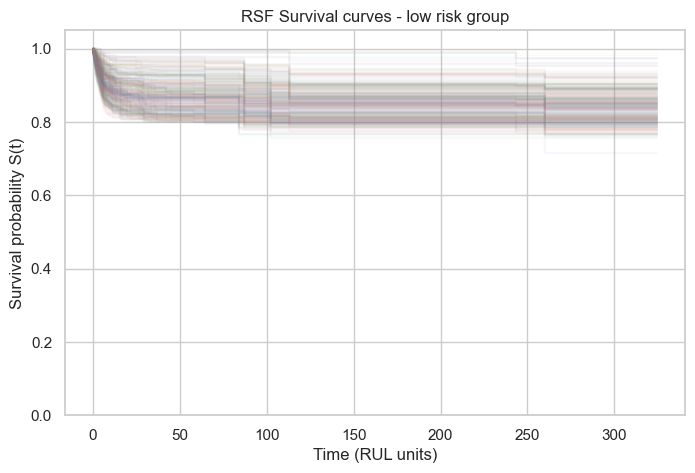

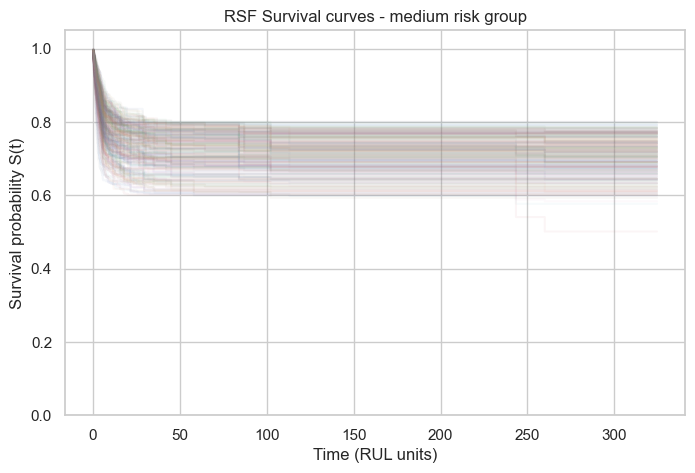

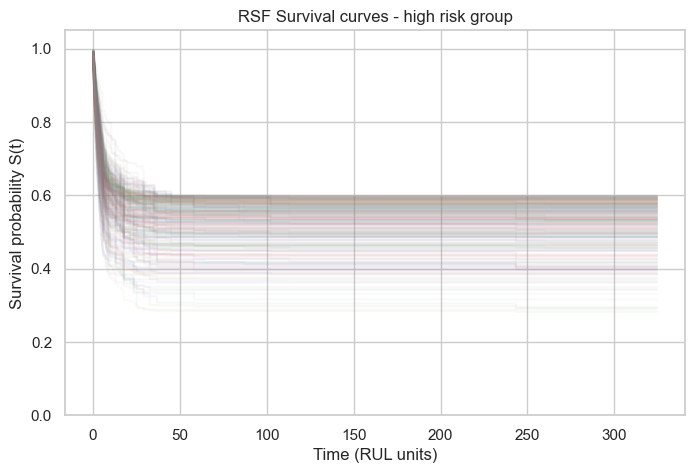

In [13]:
def plot_group_survival(group_name, max_samples=300):
    idx = df_test["risk_group"] == group_name
    surv_group = surv_matrix[idx]

    # Optionally limit number of plotted curves
    if surv_group.shape[0] > max_samples:
        surv_group = surv_group[:max_samples]

    plt.figure(figsize=(8, 5))
    for row in surv_group:
        plt.step(times, row, where="post", alpha=0.05)
    plt.xlabel("Time (RUL units)")
    plt.ylabel("Survival probability S(t)")
    plt.title(f"RSF Survival curves - {group_name} risk group")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.show()

plot_group_survival("low")
plot_group_survival("medium")
plot_group_survival("high")


In [14]:

out_path = DATA_DIR / "scania_test_with_risk.parquet"
df_test.to_parquet(out_path, index=False)
print("Saved:", out_path)
df_test.head()


Saved: E:\work\project\scania_rul_survival\data\scania_test_with_risk.parquet


,171_0,666_0,837_0,167_0,167_1,167_2,167_3,167_4,167_6,167_7,...,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,RUL,in_study_repair,vehicle_id,surv_prob_at_T,t_horizon,risk_group
12945,3267180.0,80774.0,6692.0,14121.0,14611533.0,38731894.0,13485650.0,30548482.0,11480012.0,268128.0,...,False,False,False,False,5.0,0,18521,0.840370,50.0,low
243,8399850.0,349538.0,116164.0,22281.0,12885921.0,23534515.0,16716669.0,58702569.0,14333888.0,672613.0,...,False,False,False,False,3.2,1,336,0.657211,50.0,medium
10041,3955200.0,131341.0,20981.0,3123.0,4280735.0,18775382.0,19149289.0,40064733.0,28733180.0,1371425.0,...,False,False,False,False,1.8,0,14425,0.721114,50.0,medium
13579,3583080.0,88699.0,29250.0,4070.0,5320727.0,11424708.0,10498830.0,24649757.0,16478777.0,475580.0,...,False,False,False,False,11.8,0,19409,0.804316,50.0,low
1354,6723180.0,45627.0,156.0,52521.0,9708537.0,53520074.0,54025183.0,122050774.0,1216133.0,0.0,...,False,False,False,False,1.0,0,1924,0.891631,50.0,low
